In [6]:
# !pip install matplotlib-venn
# !pip install plotly

  Using cached plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)
  Using cached retrying-1.3.3-py3-none-any.whl


In [91]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import simdkalman

In [92]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [93]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)


In [94]:
# directory setting
INPUT = '../input/google-smartphone-decimeter-challenge'


In [95]:
base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

In [96]:
# ground_truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))
print('ground_truth.csv count : ', len(gt_files))

gts = []
for gt_file in tqdm(gt_files):
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

display(ground_truth.head())

ground_truth.csv count :  73


  0%|          | 0/73 [00:00<?, ?it/s]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-21-US-MTV-1,Pixel4,1274119793431,37.424354,-122.091865,33.89,461.43,2.9,0.0,0.0,76.5
1,2020-05-21-US-MTV-1,Pixel4,1274119794431,37.424354,-122.091865,33.89,462.43,2.9,0.0,0.0,76.5
2,2020-05-21-US-MTV-1,Pixel4,1274119795431,37.424354,-122.091865,33.89,463.43,2.9,0.0,0.0,76.5
3,2020-05-21-US-MTV-1,Pixel4,1274119796431,37.424354,-122.091865,33.89,464.43,2.9,0.0,0.0,76.5
4,2020-05-21-US-MTV-1,Pixel4,1274119797431,37.424354,-122.091865,33.90,465.43,2.9,0.0,0.0,76.5


## Reject outlier

In [97]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [98]:
# reject outlier
train_ro = add_distance_diff(base_train)
th = 50
train_ro.loc[((train_ro['dist_prev'] > th) & (train_ro['dist_next'] > th)), ['latDeg', 'lngDeg']] = np.nan

<AxesSubplot:xlabel='dist_next'>

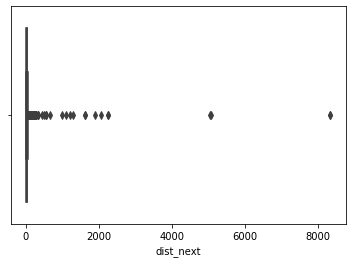

In [99]:
sns.boxplot(data=train_ro, x='dist_next')

In [100]:
train_ro.describe()

,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,latDeg_prev,latDeg_next,lngDeg_prev,lngDeg_next,dist_prev,dist_next
count,1.313420e+05,131277.000000,131277.000000,131342.000000,131269.000000,131269.000000,131269.000000,131269.000000,131269.000000,131269.000000
mean,1.287913e+12,37.435228,-122.154981,23.832922,37.435192,37.435201,-122.154910,-122.154930,19.616143,19.616143
std,1.162110e+10,0.082711,0.145947,72.589312,0.082701,0.082709,0.145965,0.145974,42.747608,42.747608
min,1.273529e+12,37.322844,-122.429241,-6157.470000,37.321683,37.321683,-122.472214,-122.472214,0.000000,0.000000
25%,1.275424e+12,37.371609,-122.275138,-26.790000,37.371564,37.371564,-122.275104,-122.275122,7.210129,7.210129
50%,1.283279e+12,37.424361,-122.118329,3.230000,37.424360,37.424360,-122.118316,-122.118354,22.484283,22.484283
75%,1.302558e+12,37.469131,-122.069147,59.410000,37.469099,37.469111,-122.069070,-122.069070,29.425198,29.425198
max,1.303771e+12,37.690836,-121.881855,13701.980000,37.690836,37.690836,-121.881855,-121.881855,8340.325453,8340.325453


In [101]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [102]:
cols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
train_ro_kf = apply_kf_smoothing(train_ro[cols])

/Users/shugo/Desktop/Competitions/kaggle/outdoor/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Phone mean prediction

In [103]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

In [104]:
def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [105]:
train_lerp = make_lerp_data(train_ro_kf)
train_mean_pred = calc_mean_pred(train_ro_kf, train_lerp)

In [106]:
tmp1 = train_ro_kf.copy()
tmp2 = train_mean_pred.copy()
tmp2['phoneName'] = tmp2['phoneName'] + '_MEAN'
tmp3 = ground_truth.copy()
tmp3['phoneName'] = tmp3['phoneName'] + '_GT'
tmp = pd.concat([tmp1, tmp2, tmp3])
# visualize_collection(tmp, '2020-05-14-US-MTV-1')

In [107]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [108]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95]) # phoneによってgroupbyし、gtと予測値の差(err)の50%,95%値を求める
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [109]:
print('kf + reject_outlier : ', get_train_score(train_ro_kf, ground_truth))
print('+ phones_mean_pred : ', get_train_score(train_mean_pred, ground_truth))

kf + reject_outlier :  4.5663933597696005
+ phones_mean_pred :  4.1238688633941525


In [110]:
base_test = add_distance_diff(base_test)
th = 50
base_test.loc[((base_test['dist_prev'] > th) & (base_test['dist_next'] > th)), ['latDeg', 'lngDeg']] = np.nan

test_kf = apply_kf_smoothing(base_test)

test_lerp = make_lerp_data(test_kf)
test_mean_pred = calc_mean_pred(test_kf, test_lerp)

sample_sub['latDeg'] = test_mean_pred['latDeg']
sample_sub['lngDeg'] = test_mean_pred['lngDeg']
sample_sub.to_csv('../output/sub_nb005.csv', index=False)